In [43]:
import pandas as pd
import numpy as np
import keras

In [44]:
from matplotlib import pyplot as plt

from keras.layers import Input, Dense
from keras.models import Model

from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

%matplotlib inline

In [45]:
df0 = pd.read_csv("flightDelay.csv")

In [46]:
df0.head()

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,8,3,6,DL,10397,14747,1754,-3.0,0.0,2013,-5.0,0,0
1,2013,4,21,7,DL,11193,13204,905,-7.0,0.0,1112,2.0,0,0
2,2013,7,9,2,AA,11298,13487,2025,35.0,1.0,2245,25.0,1,0
3,2013,5,23,4,B6,11057,10721,1000,-9.0,0.0,1208,-18.0,0,0
4,2013,5,2,4,AA,13930,11298,740,-3.0,0.0,1010,-6.0,0,0


In [47]:
df = df0[["CRSDepTime", "DepDelay", "ArrDelay"]].dropna()
n = len(df)
n_train = range( int(n/2) )
n_test = range( int(n/2)+1, n)
print(n)
print(n_train)
print(n_test)

270
range(0, 135)
range(136, 270)


In [48]:
df_train = df.iloc[n_train]
df_test  = df.iloc[n_test]



In [49]:
X_train = df_train[ ["CRSDepTime", "DepDelay"] ]
y_train = df_train[ ["ArrDelay"] ]
X_test  = df_test [ ["CRSDepTime", "DepDelay"] ]
y_test  = df_test [ ["ArrDelay"] ]

In [50]:
np.hstack( (X_test, y_test) )[ 0:5 ]

array([[ 655.,   -5.,  -18.],
       [1355.,   -9.,  -11.],
       [2210.,   40.,   31.],
       [1240.,  320.,  283.],
       [1405.,   -8.,    0.]])

In [51]:
sc = StandardScaler()
x_ = sc.fit_transform(X_train)
y_ = sc.fit_transform(y_train)

In [52]:
# see the ecplanation at 
# https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network
# about loss: nan

# Not really. These nan is because the data contrains NA. 
# use .dropna() to remove NAs.

inputs = Input(shape=(2,)) # the # of columns of the train data X
preds = Dense(1, activation='linear') (inputs)

model = Model(inputs=inputs,outputs=preds)

sgd=keras.optimizers.SGD(lr = 0.01)
# adm = keras.optimizers.Nadam(lr = 0.0001)
# adag = keras.optimizers.Adagrad(lr=0.00000001, epsilon=None, decay=0.0)
model.compile(optimizer=sgd, loss='mse')
history = model.fit(x_, y_, batch_size=1, verbose=1, epochs=10, shuffle=False)


Epoch 1/10
135/135 [==============================] - 0s 2ms/step - loss: 0.2672
Epoch 2/10
135/135 [==============================] - 0s 658us/step - loss: 0.1453
Epoch 3/10
135/135 [==============================] - 0s 584us/step - loss: 0.1436
Epoch 4/10
135/135 [==============================] - 0s 547us/step - loss: 0.1434
Epoch 5/10
135/135 [==============================] - 0s 635us/step - loss: 0.1434
Epoch 6/10
135/135 [==============================] - 0s 613us/step - loss: 0.1434
Epoch 7/10
135/135 [==============================] - 0s 613us/step - loss: 0.1434
Epoch 8/10
135/135 [==============================] - 0s 694us/step - loss: 0.1434
Epoch 9/10
135/135 [==============================] - 0s 665us/step - loss: 0.1434
Epoch 10/10
135/135 [==============================] - 0s 761us/step - loss: 0.1434


In [53]:
score = model.evaluate(X_test, y_test, verbose=0) # report the MSE
print(score)
print( np.mean( (model.predict(X_test) - y_test)**2 ) )

print(model.summary())

print(history.history )

841.5095779646689
ArrDelay    841.509591
dtype: float64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
{'loss': [0.2672259312629548, 0.14530477765804356, 0.14356928926451507, 0.14340395307781026, 0.14338273868574847, 0.14337986856104787, 0.143379478288952, 0.1433794204036699, 0.1433794204738391, 0.14337942042022944]}


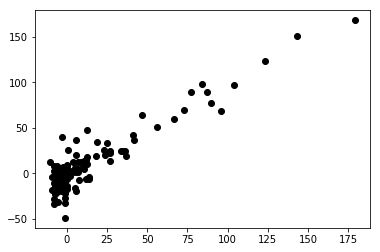

In [54]:
plt.scatter(X_train[["DepDelay"]], y_train,color='black')

In [58]:
weights = model.trainable_weights # weight tensors
print(weights)
import keras.backend as K
K.get_session().run(model.trainable_weights)

[<tf.Variable 'dense_5/kernel:0' shape=(2, 1) dtype=float32_ref>, <tf.Variable 'dense_5/bias:0' shape=(1,) dtype=float32_ref>]


[array([[0.01627794],
        [0.9000024 ]], dtype=float32), array([-0.00252398], dtype=float32)]

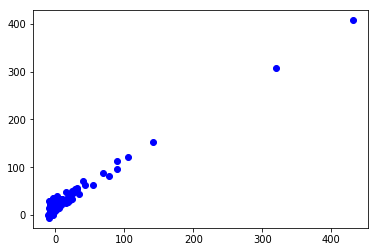

In [57]:
plt.scatter(X_test[["DepDelay"]], model.predict(X_test), color='blue', linewidth=1)